# Mountain Car Q Value Approximation

![mountain_car_0](../images/lecture_3/mountain_car_0.png)

![mountain_car_1](../images/lecture_3/mountain_car_1.png)

![mountain_car_2](../images/lecture_3/mountain_car_2.png)


## Gym Description

### Description

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
that can be applied to the car in either direction. The goal of the MDP is to strategically
accelerate the car to reach the goal state on top of the right hill. There are two versions
of the mountain car domain in gymnasium: one with discrete actions and one with continuous.
This version is the one with discrete actions.

This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)

```
@TECHREPORT{Moore90efficientmemory-based,
    author = {Andrew William Moore},
    title = {Efficient Memory-based Learning for Robot Control},
    institution = {University of Cambridge},
    year = {1990}
}
```

### Observation Space

The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:

| Num | Observation                          | Min   | Max  | Unit         |
| --- | ------------------------------------ | ----- | ---- | ------------ |
| 0   | position of the car along the x-axis | -1.2  | 0.6  | position (m) |
| 1   | velocity of the car                  | -0.07 | 0.07 | velocity (v) |

### Action Space

There are 3 discrete deterministic actions:

- 0: Accelerate to the left
- 1: Don't accelerate
- 2: Accelerate to the right

### Transition Dynamics:

Given an action, the mountain car follows the following transition dynamics:

_velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) _ force - cos(3 _ position<sub>t</sub>) _ gravity\*

_position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>_

where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0
upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and
velocity is clipped to the range `[-0.07, 0.07]`.

### Reward:

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is
penalised with a reward of -1 for each timestep.

### Starting State

The position of the car is assigned a uniform random value in _[-0.6 , -0.4]_.
The starting velocity of the car is always assigned to 0.

### Episode End

The episode ends if either of the following happens:

1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
2. Truncation: The length of the episode is 200.

### Arguments

```python
import gymnasium as gym
gym.make('MountainCar-v0')
```

On reset, the `options` parameter allows the user to change the bounds used to determine
the new random state.

### Version History

- v0: Initial versions release (1.0.0)


## Import Env

In [1]:
import gymnasium as gym
for k,v in gym.envs.registry.items():
    print(k,"\t",v)

CartPole-v0 	 EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1 	 EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0 	 EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold

In [2]:
from gymnasium.envs.classic_control.mountain_car import MountainCarEnv
env=gym.make("MountainCar-v0")
print("Observation space: ",env.observation_space)
print("Action space: ",env.action_space)

Observation space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space:  Discrete(3)


## Normalizer

In [3]:
import numpy as np


def normalizer(env: gym.Env, state: np.ndarray):
    LOW = env.observation_space.low
    HIGH = env.observation_space.high
    normalized_state = np.zeros(state.shape)
    normalized_state = (state-LOW)/(HIGH - LOW)
    return normalized_state


normalizer(env, env.reset()[0])


array([0.335337, 0.5     ], dtype=float32)

## Q Approximator

In [4]:
import torch
import torch.nn as nn


class Q_Approximator(nn.Module):
    def __init__(self, num_observations: int, num_actions: int) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(num_observations, 128)
        self.layer_2 = nn.Linear(128, num_actions)
        self.selu = nn.SELU()

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        q_actions = self.layer_1(state)
        q_actions = self.selu(q_actions)
        q_actions = self.layer_2(q_actions)
        return q_actions


## Experience

In [5]:
from collections import namedtuple, deque
from typing import List
import random
Transition = namedtuple(
    "transition", ["state", "action", "next_state", "next_action", "reward"])


class Experience:
    def __init__(self, maxlen: int) -> None:
        self.experience = deque([], maxlen)

    def append(self, transition: Transition):
        self.experience.append(transition)

    def sample(self, batch_size) -> List:
        return random.sample(self.experience, batch_size)

    def get_length(self) -> int:
        return len(self.experience)


## Epsilon Decay

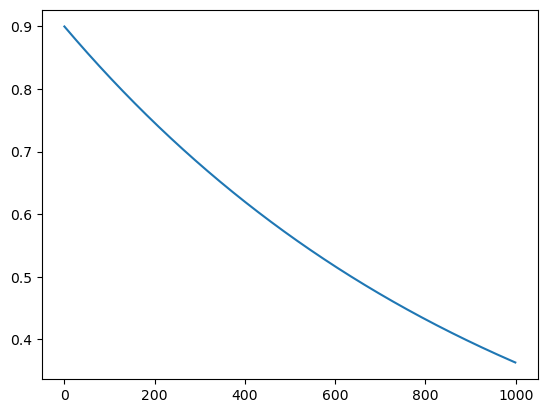

In [6]:
import numpy as np


def get_epsilon(epsilon_start: float, epsilon_end: float, num_episodes: float, step_i: int):
    """return epsilon=epsilon_end+(epsilon_start-epsilon_end)*decay_rate**step_decay"""
    epsilon = epsilon_end+(epsilon_start-epsilon_end) * \
        np.exp(-1.0*step_i/(1.0*num_episodes))
    return epsilon


def plot_epsilon(epsilon_start: float, epsilon_end: float, num_episode: float):
    import matplotlib.pyplot as plt
    xs = np.arange(num_episode)
    epsilons = np.array(
        [get_epsilon(epsilon_start, epsilon_end, num_episode, step) for step in xs])
    plt.plot(xs, epsilons)


plot_epsilon(0.9, 0.05, int(1e3))


## Epsilon-greedy

In [7]:
def epsilon_greedy(policy_net: Q_Approximator, num_actions: int, state: torch.Tensor, epsilon: float) -> int:
    probability = 1.0*np.ones(num_actions)*epsilon/num_actions
    q_actions = policy_net(state).detach().cpu().numpy()
    idx_action_with_max_q = np.argmax(q_actions)
    probability[idx_action_with_max_q] = 1-np.sum(probability[1:])
    return np.random.choice(np.arange(num_actions), p=probability)


epsilon_greedy(Q_Approximator(env.observation_space.shape[0], env.action_space.n), env.action_space.n, torch.tensor(
    env.reset()[0], dtype=torch.float32), 0.1)


1

## Learning Rate Decay

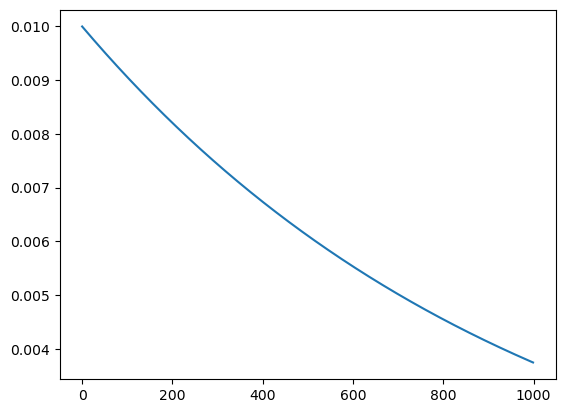

In [8]:
def get_learning_rate(learning_rate_start:float,learning_rate_end:float,num_episodes:float,step_i:int):
    """return epsilon=epsilon_end+(epsilon_start-epsilon_end)*decay_rate**step_decay"""
    learning_rate=learning_rate_end+(learning_rate_start-learning_rate_end)*np.exp(-1.0*step_i/num_episodes)
    return learning_rate

def plot_learning_rate(epsilon_start: float, epsilon_end: float, num_episode: float):
    import matplotlib.pyplot as plt
    xs = np.arange(num_episode)
    lrs = np.array(
        [get_learning_rate(epsilon_start, epsilon_end, num_episode, step) for step in xs])
    plt.plot(xs, lrs)


plot_learning_rate(1e-2, 1e-4, int(1e3))

In [9]:
def sarsa_update_policy_net(env:gym.Env, policy_net:Q_Approximator,target_net:Q_Approximator,
                                experience:Experience,batch_size:int,
                                learning_rate:float,gamma:float,
                                loss_fn:nn.Module,optimizer:torch.optim.Optimizer,
                                device:str):
    
    # set up learning rate
    for g in optimizer.param_groups:
        g['lr']=learning_rate
    
    batch=experience.sample(batch_size)
    [batch_state,batch_action,batch_next_state,batch_next_action,batch_reward]=zip(*batch)
    batch_state=np.array([normalizer(env,state) for state in batch_state])
    batch_action=np.array([action for action in batch_action])
    mask_batch_next_state_is_not_none=np.array([next_state is not None for next_state in batch_next_state])
    batch_not_none_next_state=np.array([normalizer(env,next_state) for next_state in batch_next_state if next_state is not None])
    batch_not_none_next_action=np.array(batch_next_action)[mask_batch_next_state_is_not_none]
    batch_reward=np.array(batch_reward)
    
    batch_state=torch.tensor(batch_state,dtype=torch.float32,device=device)
    batch_action=torch.tensor(batch_action,dtype=torch.int64,device=device).unsqueeze(-1)
    mask_batch_next_state_is_not_none=torch.tensor(mask_batch_next_state_is_not_none,dtype=torch.bool,device=device)
    batch_not_none_next_state=torch.tensor(batch_not_none_next_state,dtype=torch.float32,device=device)
    batch_not_none_next_action=torch.tensor(batch_not_none_next_action,dtype=torch.int64,device=device).unsqueeze(-1)
    batch_reward=torch.tensor(batch_reward,dtype=torch.float32,device=device).unsqueeze(-1)
    
    q_state_action=policy_net(batch_state).gather(1,batch_action)
    q_next_state_action=torch.zeros(q_state_action.size(),device=device)
    with torch.no_grad():
        q_next_state_action[mask_batch_next_state_is_not_none]=target_net(batch_not_none_next_state).gather(1,batch_not_none_next_action)
    q_target=batch_reward+gamma*q_next_state_action
    
    optimizer.zero_grad()
    loss=loss_fn(q_state_action,q_target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    

## SARSA

In [10]:
from collections import defaultdict


def sarsa(env: gym.Env, num_episodes: int = int(1e3),
          experience_maxlen: int = 2**10, batch_size: int = 64,
          gamma: float = 0.9,
          learning_rate_start: float = 1e-3, learning_rate_end: float = 1e-4,
          epsilon_start: float = 0.9, epsilon_end: float = 0.05,
          tau=0.005,
          device: str = "cpu",
          print_step: int = 100):
    policy_net = Q_Approximator(
        env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = Q_Approximator(
        env.observation_space.shape[0], env.action_space.n).to(device)

    loss_fn = nn.SmoothL1Loss()
    optimizer = torch.optim.SGD(policy_net.parameters(), learning_rate_start)

    experience = Experience(experience_maxlen)

    num_attempts_per_episode = defaultdict(int)
    reward_per_episode = defaultdict(float)

    loss = 0.0

    for episode_i in range(num_episodes):

        epsilon = get_epsilon(epsilon_start, epsilon_end,
                              num_episodes, episode_i)
        learning_rate = get_learning_rate(
            learning_rate_start, learning_rate_end, num_episodes, episode_i)

        state = env.reset()[0]
        action = epsilon_greedy(policy_net, env.action_space.n, torch.tensor(
            normalizer(env, state), dtype=torch.float32, device=device), epsilon)

        is_terminated = False

        while not is_terminated:
            next_state, reward, is_terminated, is_truncated, info = env.step(
                action)
            next_action = epsilon_greedy(policy_net, env.action_space.n, torch.tensor(
                normalizer(env, next_state), dtype=torch.float32, device=device), epsilon)
            if is_terminated:
                next_state = None
            experience.append(Transition(
                state, action, next_state, next_action, reward))

            state = next_state
            action = next_action

            if experience.get_length() >= batch_size:
                loss = sarsa_update_policy_net(
                    env, policy_net, target_net, experience, batch_size, learning_rate, gamma, loss_fn, optimizer, device)

                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * \
                        tau + target_net_state_dict[key]*(1-tau)
                target_net.load_state_dict(target_net_state_dict)

            num_attempts_per_episode[episode_i] += 1
            reward_per_episode[episode_i] += reward

        if episode_i % print_step == 0:
            print("episode %d, loss %f, num_attempts %d" %
                  (episode_i, loss, num_attempts_per_episode[episode_i]))

    return policy_net, num_attempts_per_episode, reward_per_episode


In [11]:
import time
t_start = time.time()
sarsa_policy_net, sarsa_num_attempts_per_episode, sarsa_reward_per_episode = sarsa(env, num_episodes=int(1e3), experience_maxlen=2**10, batch_size=128, gamma=0.9, learning_rate_start=1e-6, learning_rate_end=1e-7, epsilon_start=0.9, epsilon_end=0.05, tau=0.005, device="cuda" if torch.cuda.is_available() else "cpu", print_step=1)
t_end = time.time()
print("training cost: ", t_end-t_start)


episode 0, loss 0.478830, num_attempts 12871
episode 1, loss 0.468237, num_attempts 9335
episode 2, loss 0.449353, num_attempts 6257
episode 3, loss 0.442487, num_attempts 5476
episode 4, loss 0.420891, num_attempts 17330
episode 5, loss 0.411316, num_attempts 10456
episode 6, loss 0.406867, num_attempts 1479
episode 7, loss 0.414839, num_attempts 1221
episode 8, loss 0.404100, num_attempts 1179
episode 9, loss 0.399224, num_attempts 5629
episode 10, loss 0.396436, num_attempts 1943
episode 11, loss 0.380757, num_attempts 1200
episode 12, loss 0.395834, num_attempts 4542
episode 13, loss 0.387859, num_attempts 1344
episode 14, loss 0.389865, num_attempts 1130
episode 15, loss 0.386236, num_attempts 657
episode 16, loss 0.387535, num_attempts 5262
episode 17, loss 0.381242, num_attempts 805
episode 18, loss 0.382777, num_attempts 1124
episode 19, loss 0.378016, num_attempts 1277
episode 20, loss 0.387569, num_attempts 849
episode 21, loss 0.385599, num_attempts 2145
episode 22, loss 0.3

## Save the Result

In [12]:
torch.save(sarsa_policy_net.state_dict(),"saves/MountainCar-v0-sarsa.pth")

## Plot Train Result

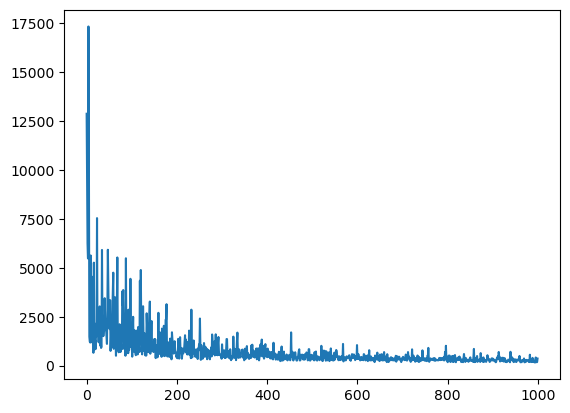

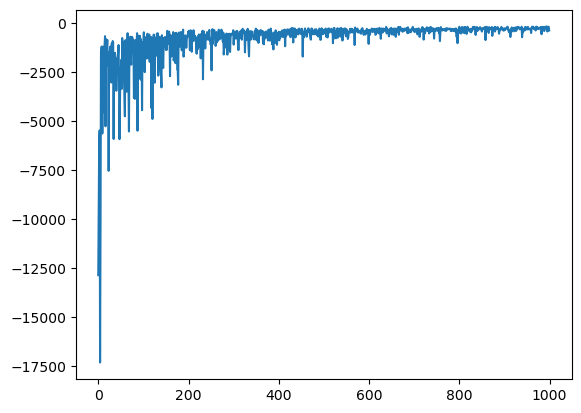

In [13]:
import matplotlib.pyplot as plt
from typing import Dict
def plot_num_attempts_per_episode(num_attempts_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(num_attempts_per_episode.keys(),num_attempts_per_episode.values())
    
def plot_reward_per_episode(reward_per_episode:Dict):
    fig,ax=plt.subplots()
    ax.plot(reward_per_episode.keys(),reward_per_episode.values())
    
plot_num_attempts_per_episode(sarsa_num_attempts_per_episode)
plot_reward_per_episode(sarsa_reward_per_episode)

## Test the Policy

In [14]:
def test_policy(env: gym.Env, policy_net: Q_Approximator, num_tests: int, device: str):
    num_attempts = []
    for test_i in range(num_tests):
        state = env.reset()[0]
        num_trying_step = 0
        is_terminated = False
        while not is_terminated:
            normalized_state = normalizer(env, state)
            q_actions = torch.zeros((env.action_space.n, 1))
            with torch.no_grad():
                q_actions = policy_net(torch.tensor(
                    normalized_state, dtype=torch.float32, device=device))
            action = torch.argmax(q_actions).detach().cpu().item()
            state, reward, is_terminated, is_truncated, info = env.step(action)
            num_trying_step += 1
        num_attempts.append(num_trying_step)
        print("test %d, take %d steps" % (test_i, num_trying_step))
    print("Average trying step :%f" % (1.0*np.sum(num_attempts)/num_tests))


test_policy(env, sarsa_policy_net, int(1e3),
            device="cuda" if torch.cuda.is_available() else "cpu")


test 0, take 163 steps
test 1, take 162 steps
test 2, take 163 steps
test 3, take 168 steps
test 4, take 130 steps
test 5, take 162 steps
test 6, take 165 steps
test 7, take 162 steps
test 8, take 162 steps
test 9, take 167 steps
test 10, take 165 steps
test 11, take 162 steps
test 12, take 167 steps
test 13, take 162 steps
test 14, take 163 steps
test 15, take 167 steps
test 16, take 161 steps
test 17, take 166 steps
test 18, take 130 steps
test 19, take 167 steps
test 20, take 163 steps
test 21, take 163 steps
test 22, take 162 steps
test 23, take 162 steps
test 24, take 163 steps
test 25, take 161 steps
test 26, take 131 steps
test 27, take 165 steps
test 28, take 131 steps
test 29, take 162 steps
test 30, take 162 steps
test 31, take 167 steps
test 32, take 163 steps
test 33, take 165 steps
test 34, take 167 steps
test 35, take 163 steps
test 36, take 162 steps
test 37, take 163 steps
test 38, take 132 steps
test 39, take 167 steps
test 40, take 163 steps
test 41, take 161 steps
te

test 254, take 128 steps
test 255, take 163 steps
test 256, take 166 steps
test 257, take 167 steps
test 258, take 163 steps
test 259, take 164 steps
test 260, take 162 steps
test 261, take 129 steps
test 262, take 163 steps
test 263, take 161 steps
test 264, take 167 steps
test 265, take 163 steps
test 266, take 162 steps
test 267, take 163 steps
test 268, take 162 steps
test 269, take 162 steps
test 270, take 167 steps
test 271, take 164 steps
test 272, take 162 steps
test 273, take 167 steps
test 274, take 162 steps
test 275, take 163 steps
test 276, take 163 steps
test 277, take 130 steps
test 278, take 166 steps
test 279, take 162 steps
test 280, take 167 steps
test 281, take 129 steps
test 282, take 128 steps
test 283, take 163 steps
test 284, take 164 steps
test 285, take 162 steps
test 286, take 163 steps
test 287, take 163 steps
test 288, take 168 steps
test 289, take 128 steps
test 290, take 163 steps
test 291, take 129 steps
test 292, take 129 steps
test 293, take 162 steps
